<a href="https://colab.research.google.com/github/zahraniayudyaa/TUGAS-ML/blob/main/ch_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Pengantar Dimensionality Reduction**
---
Dimensionality Reduction (Reduksi Dimensi) adalah teknik untuk mengurangi jumlah fitur dalam dataset sambil mempertahankan informasi penting. Masalah dengan fitur berjumlah banyak (ribuan atau jutaan) disebut curse of dimensionality, yang menyebabkan:
* Training menjadi sangat lambat
* Kesulitan menemukan solusi optimal
* Risiko overfitting meningkat

Namun, dalam dataset nyata, seringkali banyak fitur yang redundant atau tidak informatif. Dengan mengurangi dimensi, kita dapat:
* Mempercepat training
* Visualisasi data (DataViz) menjadi mungkin
* Terkadang meningkatkan performa dengan menghilangkan noise

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_swiss_roll, make_moons
import warnings
warnings.filterwarnings('ignore')

# Set style untuk visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# **2. The Curse of Dimensionality**
---
Di ruang berdimensi tinggi, perilaku data sangat berbeda dengan intuisi kita di ruang 3D:
* Sebagian besar titik berada dekat dengan border/batas
* Jarak rata-rata antar titik menjadi sangat besar
* Data menjadi sparse (jarang)

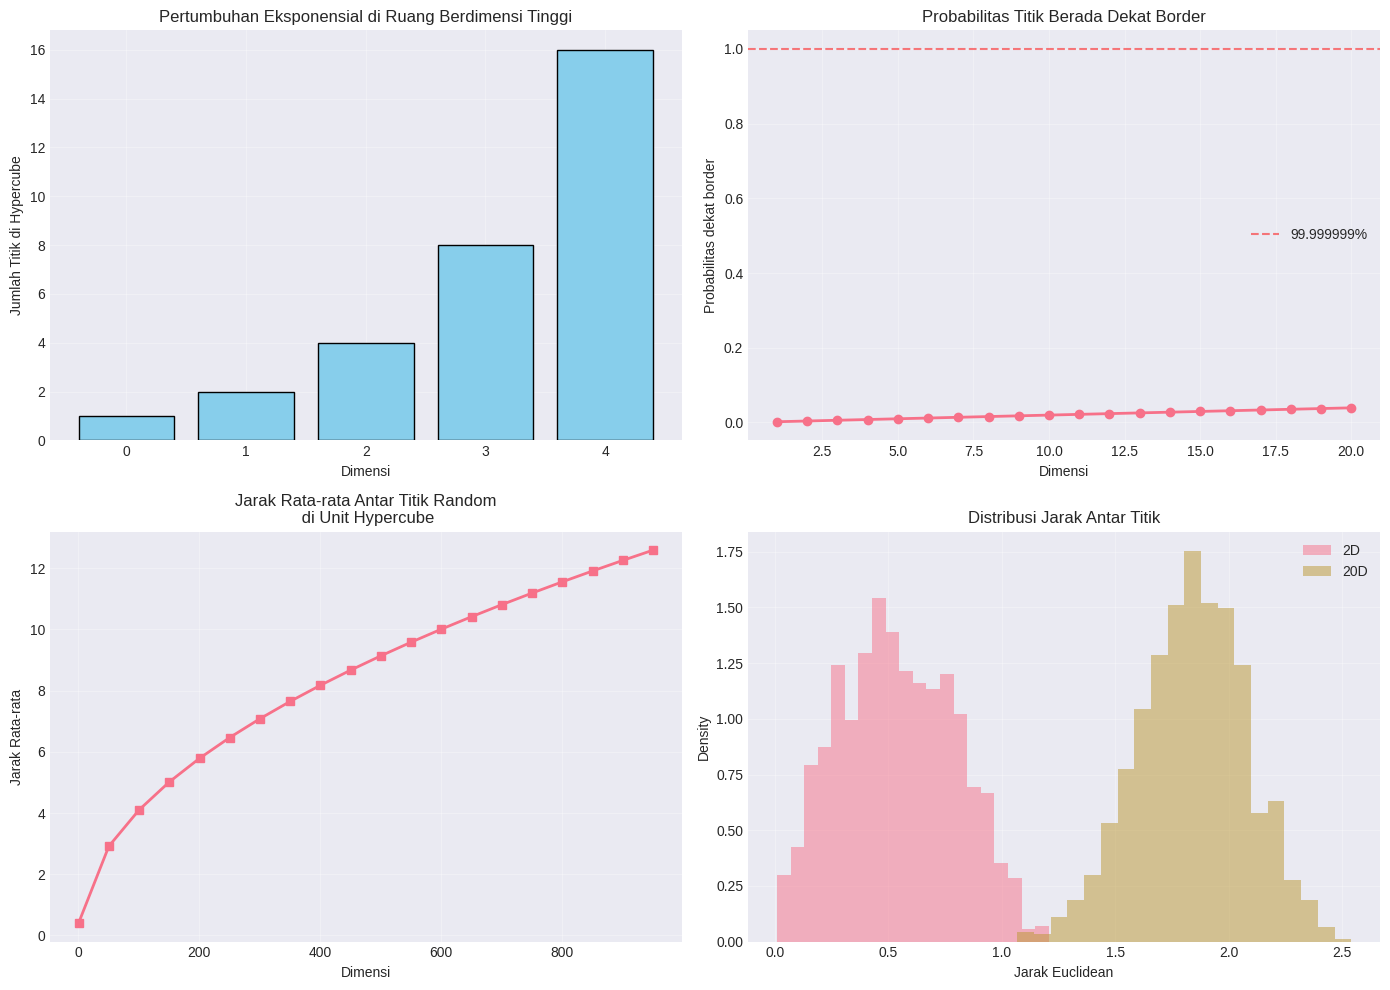

INSIGHT CURSE OF DIMENSIONALITY:
1. Di 10D: Probabilitas titik dekat border > 99.999999%
2. Di 1,000,000D: Jarak rata-rata ≈ 408 (sangat besar!)
3. Data menjadi sangat sparse di dimensi tinggi
4. Diperlukan dataset sangat besar untuk mencapai density yang memadai


In [2]:
# Visualisasi curse of dimensionality
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Visualisasi hypercubes dari 0D hingga 4D
dimensions = [0, 1, 2, 3, 4]
points_per_dim = [1, 2, 4, 8, 16]

axes[0, 0].bar(dimensions, points_per_dim, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Dimensi')
axes[0, 0].set_ylabel('Jumlah Titik di Hypercube')
axes[0, 0].set_title('Pertumbuhan Eksponensial di Ruang Berdimensi Tinggi')
axes[0, 0].grid(True, alpha=0.3)

# 2. Probabilitas titik berada dekat border
def probability_near_border(dim, epsilon=0.001):
    return 1 - (1 - 2*epsilon)**dim

dims = np.arange(1, 21)
probs = [probability_near_border(d) for d in dims]

axes[0, 1].plot(dims, probs, marker='o', linewidth=2)
axes[0, 1].axhline(y=0.99999999, color='r', linestyle='--', alpha=0.5, label='99.999999%')
axes[0, 1].set_xlabel('Dimensi')
axes[0, 1].set_ylabel('Probabilitas dekat border')
axes[0, 1].set_title('Probabilitas Titik Berada Dekat Border')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Jarak rata-rata antar titik random
def avg_distance(dim):
    return np.sqrt(dim/6)

dims_high = np.arange(1, 1001, 50)
avg_distances = [avg_distance(d) for d in dims_high]

axes[1, 0].plot(dims_high, avg_distances, marker='s', linewidth=2)
axes[1, 0].set_xlabel('Dimensi')
axes[1, 0].set_ylabel('Jarak Rata-rata')
axes[1, 0].set_title('Jarak Rata-rata Antar Titik Random\n di Unit Hypercube')
axes[1, 0].grid(True, alpha=0.3)

# 4. Visualisasi sparsity di dimensi tinggi
np.random.seed(42)
points_2d = np.random.rand(50, 2)
points_20d = np.random.rand(50, 20)

# Hitung semua pairwise distances
from scipy.spatial.distance import pdist

dist_2d = pdist(points_2d)
dist_20d = pdist(points_20d)

axes[1, 1].hist(dist_2d, bins=20, alpha=0.5, label='2D', density=True)
axes[1, 1].hist(dist_20d, bins=20, alpha=0.5, label='20D', density=True)
axes[1, 1].set_xlabel('Jarak Euclidean')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Distribusi Jarak Antar Titik')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("INSIGHT CURSE OF DIMENSIONALITY:")
print("1. Di 10D: Probabilitas titik dekat border > 99.999999%")
print("2. Di 1,000,000D: Jarak rata-rata ≈ 408 (sangat besar!)")
print("3. Data menjadi sangat sparse di dimensi tinggi")
print("4. Diperlukan dataset sangat besar untuk mencapai density yang memadai")

# **3. Main Approaches: Projection dan Manifold Learning**
---
Ada dua pendekatan utama reduksi dimensi:
* **Projection:** Memproyeksikan data ke subspace berdimensi lebih rendah
* **Manifold Learning:** Mengungkap struktur manifold berdimensi rendah dalam data

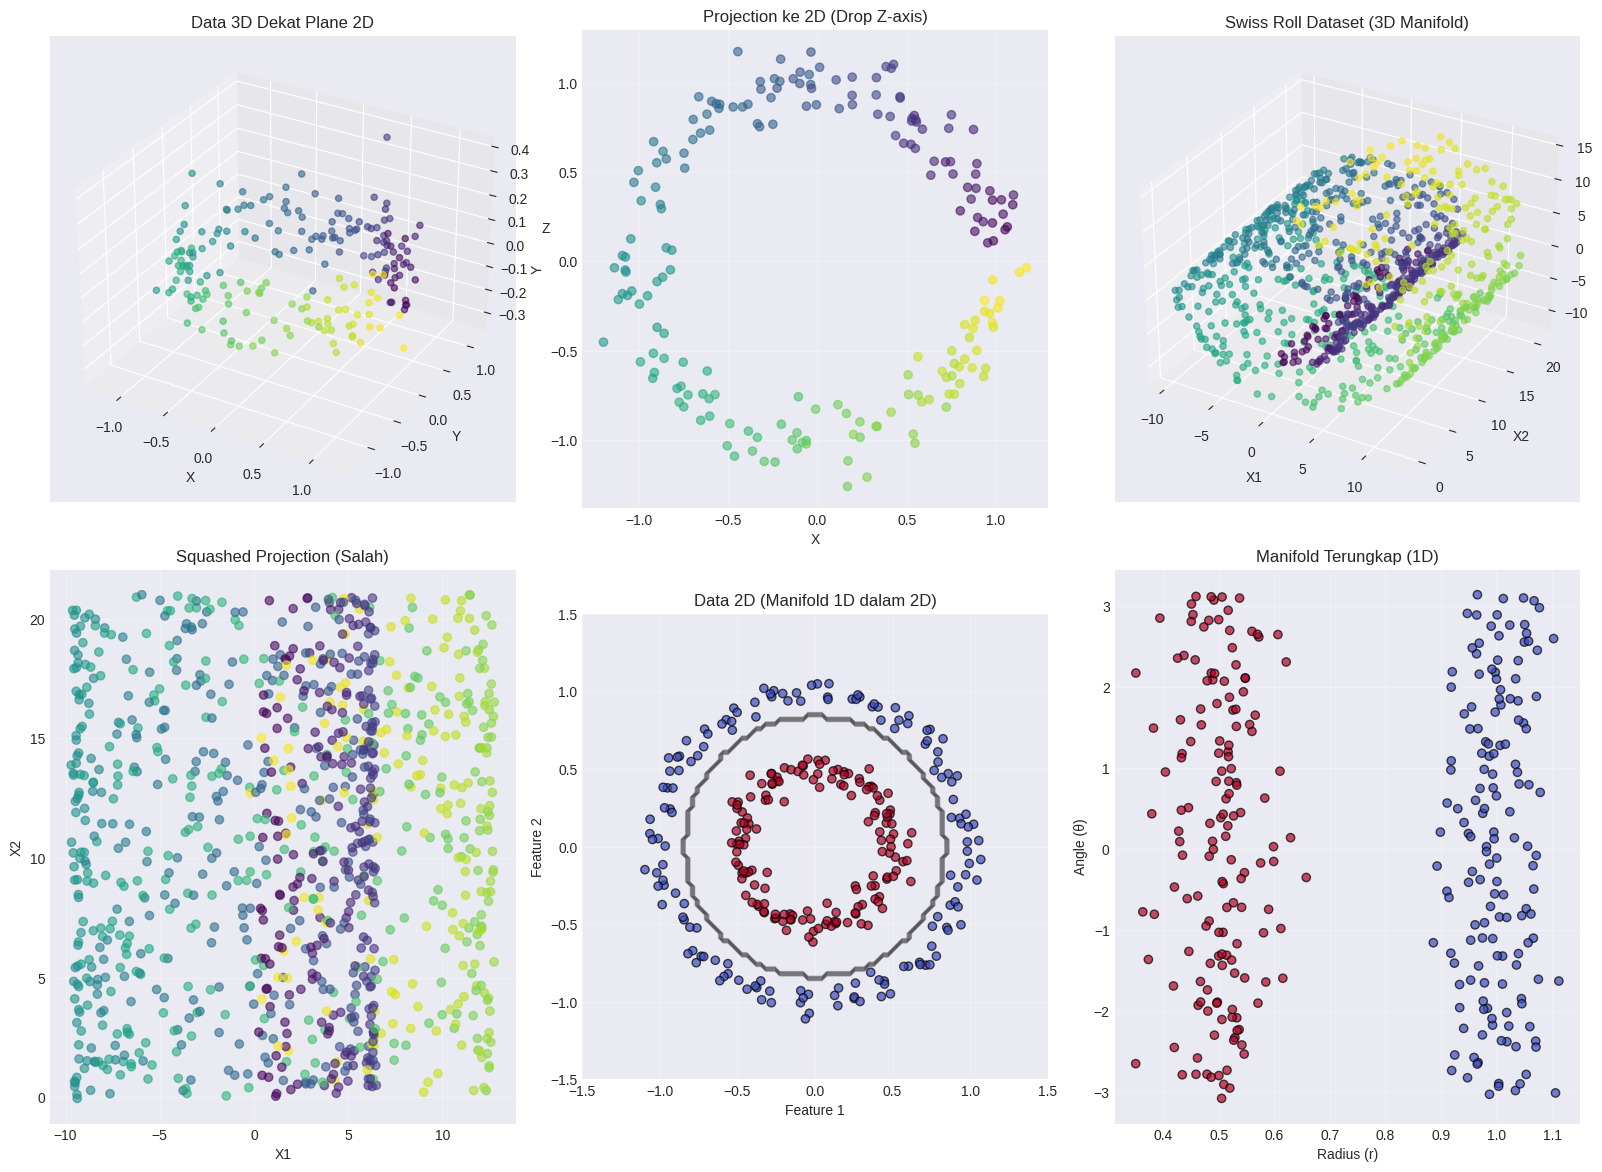

PERBEDAAN PROJECTION vs MANIFOLD LEARNING:

PROJECTION:
- Cocok ketika data berada di/sekitar subspace linear
- Contoh: PCA (Principal Component Analysis)
- Sederhana dan cepat

MANIFOLD LEARNING:
- Cocok ketika data berada pada manifold nonlinear
- Contoh: Swiss Roll, data lingkaran
- Memerlukan algoritma khusus: LLE, Isomap, t-SNE
- Dapat mengungkap struktur yang tersembunyi


In [3]:
# Visualisasi Projection vs Manifold Learning
fig = plt.figure(figsize=(16, 12))

# 1. Contoh Projection sederhana
np.random.seed(42)
n_points = 200

# Buat data 3D yang terletak dekat plane 2D
t = np.random.rand(n_points) * 2 * np.pi
z = np.random.randn(n_points) * 0.1  # Noise kecil
x = np.cos(t) + np.random.randn(n_points) * 0.1
y = np.sin(t) + np.random.randn(n_points) * 0.1

ax1 = fig.add_subplot(2, 3, 1, projection='3d')
ax1.scatter(x, y, z, c=t, cmap='viridis', alpha=0.6)
ax1.set_title('Data 3D Dekat Plane 2D')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Projection ke 2D (dengan menghilangkan z)
ax2 = fig.add_subplot(2, 3, 2)
ax2.scatter(x, y, c=t, cmap='viridis', alpha=0.6)
ax2.set_title('Projection ke 2D (Drop Z-axis)')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)

# 2. Contoh Manifold: Swiss Roll
X_swiss, t_swiss = make_swiss_roll(n_samples=1000, noise=0.1, random_state=42)

ax3 = fig.add_subplot(2, 3, 3, projection='3d')
ax3.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2],
           c=t_swiss, cmap='viridis', alpha=0.6)
ax3.set_title('Swiss Roll Dataset (3D Manifold)')
ax3.set_xlabel('X1')
ax3.set_ylabel('X2')
ax3.set_zlabel('X3')

# Projection sederhana (salah) untuk Swiss Roll
ax4 = fig.add_subplot(2, 3, 4)
ax4.scatter(X_swiss[:, 0], X_swiss[:, 1], c=t_swiss, cmap='viridis', alpha=0.6)
ax4.set_title('Squashed Projection (Salah)')
ax4.set_xlabel('X1')
ax4.set_ylabel('X2')
ax4.grid(True, alpha=0.3)

# 3. Visualisasi Manifold Assumption
from sklearn.datasets import make_circles

X_circle, y_circle = make_circles(n_samples=300, factor=0.5, noise=0.05, random_state=42)

ax5 = fig.add_subplot(2, 3, 5)
scatter = ax5.scatter(X_circle[:, 0], X_circle[:, 1], c=y_circle,
                     cmap='coolwarm', alpha=0.7, edgecolors='black')
ax5.set_title('Data 2D (Manifold 1D dalam 2D)')
ax5.set_xlabel('Feature 1')
ax5.set_ylabel('Feature 2')
ax5.set_aspect('equal')
ax5.grid(True, alpha=0.3)

# Tambahkan visualisasi decision boundary
xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 100),
                     np.linspace(-1.5, 1.5, 100))
# Simple decision boundary berdasarkan radius
Z = (xx**2 + yy**2 < 0.7).astype(int)
ax5.contour(xx, yy, Z, colors='black', alpha=0.3, linewidths=1)

ax6 = fig.add_subplot(2, 3, 6)
# Transformasi polar coordinates (ungkap manifold 1D)
r = np.sqrt(X_circle[:, 0]**2 + X_circle[:, 1]**2)
theta = np.arctan2(X_circle[:, 1], X_circle[:, 0])

scatter = ax6.scatter(r, theta, c=y_circle, cmap='coolwarm',
                     alpha=0.7, edgecolors='black')
ax6.set_title('Manifold Terungkap (1D)')
ax6.set_xlabel('Radius (r)')
ax6.set_ylabel('Angle (θ)')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("PERBEDAAN PROJECTION vs MANIFOLD LEARNING:")
print("\nPROJECTION:")
print("- Cocok ketika data berada di/sekitar subspace linear")
print("- Contoh: PCA (Principal Component Analysis)")
print("- Sederhana dan cepat")

print("\nMANIFOLD LEARNING:")
print("- Cocok ketika data berada pada manifold nonlinear")
print("- Contoh: Swiss Roll, data lingkaran")
print("- Memerlukan algoritma khusus: LLE, Isomap, t-SNE")
print("- Dapat mengungkap struktur yang tersembunyi")

# **4. Principal Component Analysis (PCA)**
---
PCA adalah algoritma reduksi dimensi paling populer. PCA:
* Mencari hyperplane terdekat dengan data
* Memproyeksikan data ke hyperplane tersebut
* Mempertahankan variance sebanyak mungkin

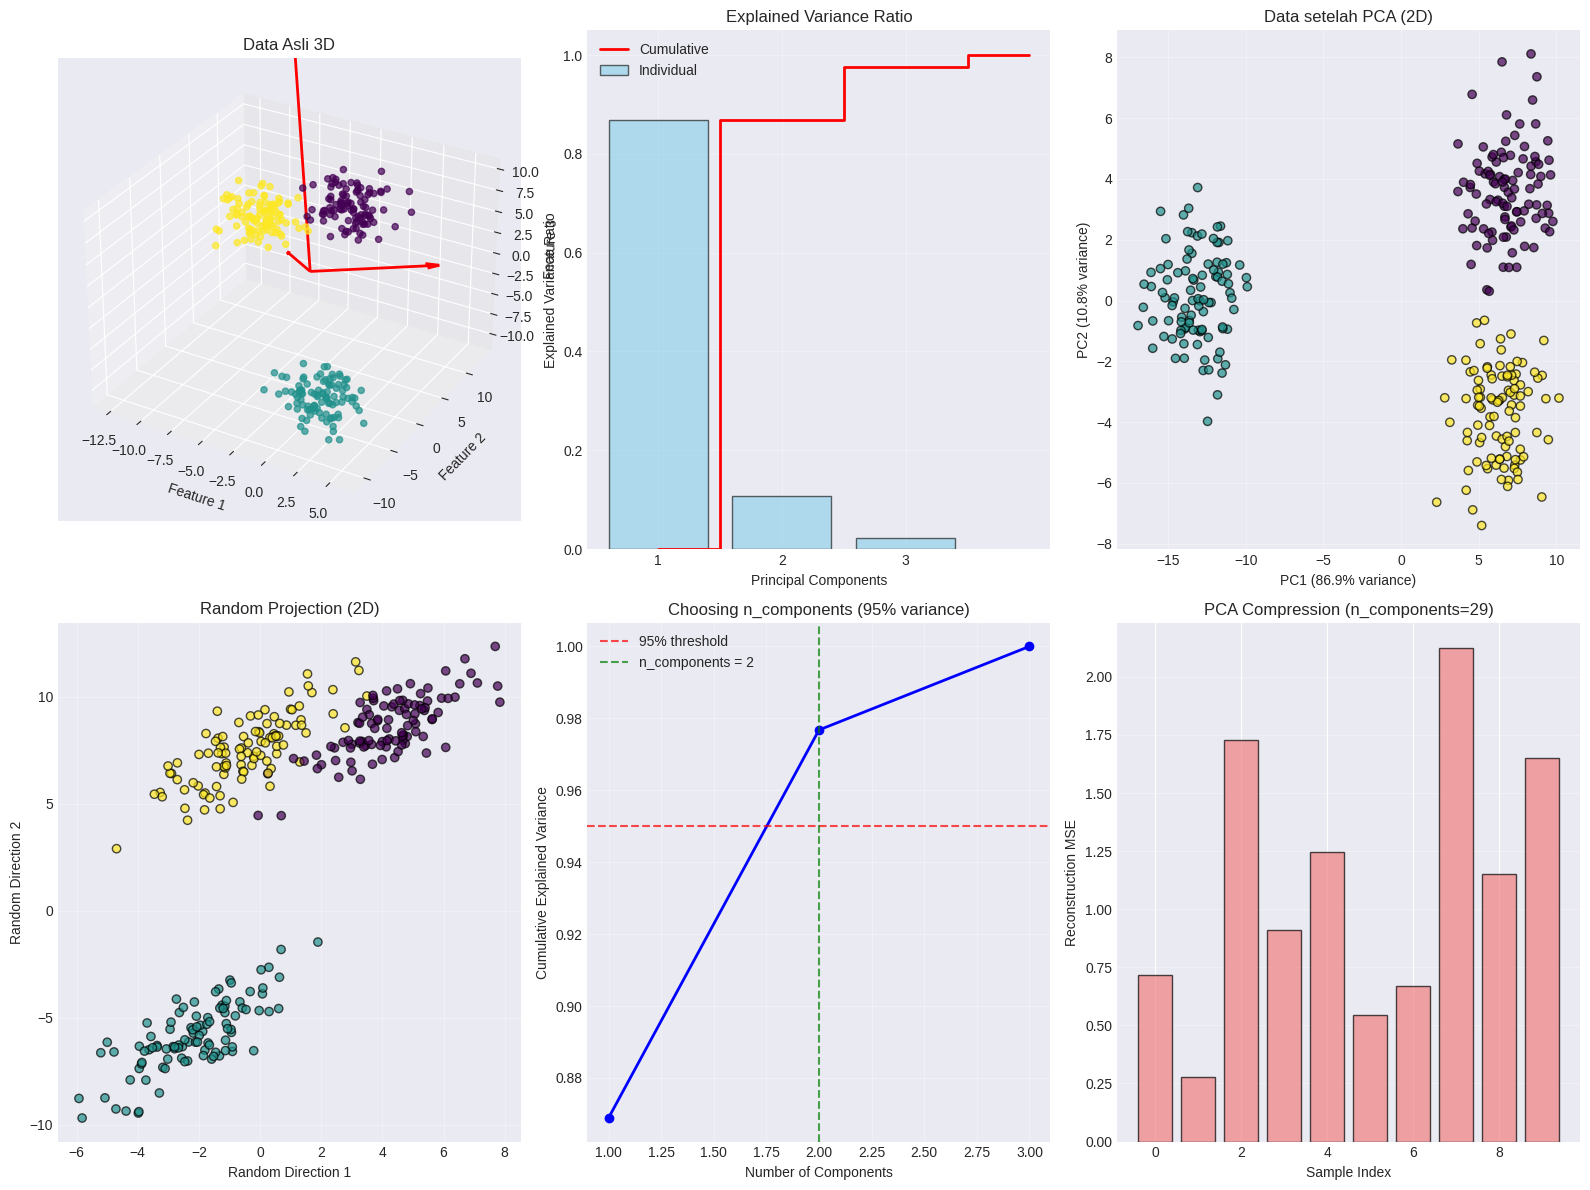

INFORMASI PCA:
Original dimensions: 3
PCA dimensions (95% variance): 2
Compression ratio: 66.7%

Explained variance ratio:
  PC1: 86.9%
  PC2: 10.8%
  PC3: 2.3%


In [4]:
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs

# Buat dataset contoh
X, y = make_blobs(n_samples=300, n_features=3, centers=3,
                  cluster_std=1.5, random_state=42)

# Visualisasi PCA
fig = plt.figure(figsize=(16, 12))

# 1. Data asli 3D
ax1 = fig.add_subplot(2, 3, 1, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis', alpha=0.7)
ax1.set_title('Data Asli 3D')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.set_zlabel('Feature 3')

# 2. Menerapkan PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Plot principal components
mean = np.mean(X, axis=0)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    ax1.quiver(mean[0], mean[1], mean[2],
               v[0], v[1], v[2],
               color='r', arrow_length_ratio=0.1, linewidth=2)

# 3. Explained Variance Ratio
ax2 = fig.add_subplot(2, 3, 2)
var_ratio = pca.explained_variance_ratio_
cum_var = np.cumsum(var_ratio)

bars = ax2.bar(range(1, 4), var_ratio, alpha=0.6, color='skyblue',
              edgecolor='black', label='Individual')
ax2.step(range(1, 5), np.append([0], cum_var), where='mid',
        linewidth=2, color='red', label='Cumulative')
ax2.set_xlabel('Principal Components')
ax2.set_ylabel('Explained Variance Ratio')
ax2.set_title('Explained Variance Ratio')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xticks([1, 2, 3])

# 4. Data setelah PCA (2D)
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X)

ax3 = fig.add_subplot(2, 3, 3)
scatter = ax3.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y,
                     cmap='viridis', alpha=0.7, edgecolors='black')
ax3.set_title('Data setelah PCA (2D)')
ax3.set_xlabel('PC1 ({:.1%} variance)'.format(pca_2d.explained_variance_ratio_[0]))
ax3.set_ylabel('PC2 ({:.1%} variance)'.format(pca_2d.explained_variance_ratio_[1]))
ax3.grid(True, alpha=0.3)

# 5. Comparison dengan proyeksi acak
np.random.seed(42)
random_proj = np.random.randn(3, 2)
random_proj /= np.linalg.norm(random_proj, axis=0)
X_random = X.dot(random_proj)

ax4 = fig.add_subplot(2, 3, 4)
scatter = ax4.scatter(X_random[:, 0], X_random[:, 1], c=y,
                     cmap='viridis', alpha=0.7, edgecolors='black')
ax4.set_title('Random Projection (2D)')
ax4.set_xlabel('Random Direction 1')
ax4.set_ylabel('Random Direction 2')
ax4.grid(True, alpha=0.3)

# 6. Reconstruction Error
pca_full = PCA()
pca_full.fit(X)

# Cari optimal n_components untuk 95% variance
cumsum = np.cumsum(pca_full.explained_variance_ratio_)
d_95 = np.argmax(cumsum >= 0.95) + 1

ax5 = fig.add_subplot(2, 3, 5)
ax5.plot(range(1, len(cumsum)+1), cumsum, 'bo-', linewidth=2)
ax5.axhline(y=0.95, color='r', linestyle='--', alpha=0.7, label='95% threshold')
ax5.axvline(x=d_95, color='g', linestyle='--', alpha=0.7,
           label=f'n_components = {d_95}')
ax5.set_xlabel('Number of Components')
ax5.set_ylabel('Cumulative Explained Variance')
ax5.set_title('Choosing n_components (95% variance)')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 7. Visualisasi PCA untuk compression
from sklearn.datasets import load_digits

digits = load_digits()
X_digits = digits.data
y_digits = digits.target

# Ambil beberapa digit untuk ditampilkan
sample_indices = np.random.choice(len(X_digits), 10, replace=False)
X_sample = X_digits[sample_indices]
y_sample = y_digits[sample_indices]

# Lakukan PCA untuk compression
pca_digits = PCA(n_components=0.95)  # Pertahankan 95% variance
X_digits_reduced = pca_digits.fit_transform(X_digits)
X_digits_recovered = pca_digits.inverse_transform(X_digits_reduced)

ax6 = fig.add_subplot(2, 3, 6)
# Hitung reconstruction error untuk sample
mse_samples = np.mean((X_sample - pca_digits.inverse_transform(
    pca_digits.transform(X_sample)))**2, axis=1)
ax6.bar(range(len(sample_indices)), mse_samples,
       color='lightcoral', edgecolor='black', alpha=0.7)
ax6.set_xlabel('Sample Index')
ax6.set_ylabel('Reconstruction MSE')
ax6.set_title(f'PCA Compression (n_components={pca_digits.n_components_})')
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Tampilkan informasi PCA
print("INFORMASI PCA:")
print(f"Original dimensions: {X.shape[1]}")
print(f"PCA dimensions (95% variance): {d_95}")
print(f"Compression ratio: {d_95/X.shape[1]:.1%}")
print(f"\nExplained variance ratio:")
for i, ratio in enumerate(var_ratio, 1):
    print(f"  PC{i}: {ratio:.1%}")

# **5. Variants of PCA**
---
1. Randomized PCA   
Randomized PCA menggunakan algoritma stochastic untuk memperkirakan principal components dengan lebih cepat, terutama ketika d jauh lebih kecil daripada n.

In [5]:
from sklearn.decomposition import PCA as RandomizedPCA
import time

# Bandingkan waktu komputasi
n_samples, n_features = 1000, 1000
X_large = np.random.randn(n_samples, n_features)

print("Perbandingan Waktu Komputasi PCA:")
print("-" * 40)

# Full PCA
start = time.time()
pca_full = PCA(n_components=100, svd_solver='full')
pca_full.fit(X_large)
full_time = time.time() - start
print(f"Full SVD PCA: {full_time:.3f} detik")

# Randomized PCA
start = time.time()
pca_random = PCA(n_components=100, svd_solver='randomized', random_state=42)
pca_random.fit(X_large)
random_time = time.time() - start
print(f"Randomized PCA: {random_time:.3f} detik")
print(f"Speedup: {full_time/random_time:.1f}x")

Perbandingan Waktu Komputasi PCA:
----------------------------------------
Full SVD PCA: 3.194 detik
Randomized PCA: 0.799 detik
Speedup: 4.0x


2. Incremental PCA  
IPCA memungkinkan PCA pada dataset yang sangat besar dengan memproses data dalam mini-batches.

In [6]:
from sklearn.decomposition import IncrementalPCA

# Simulasi Incremental PCA
print("\nSimulasi Incremental PCA:")
print("-" * 40)

# Buat dataset besar
n_samples, n_features = 5000, 100
X_big = np.random.randn(n_samples, n_features)

# Regular PCA (memerlukan semua data di memory)
start = time.time()
pca_regular = PCA(n_components=20)
pca_regular.fit(X_big)
print(f"Regular PCA time: {time.time() - start:.3f} detik")

# Incremental PCA dengan mini-batches
batch_size = 100
n_batches = n_samples // batch_size

start = time.time()
inc_pca = IncrementalPCA(n_components=20, batch_size=batch_size)

for batch in np.array_split(X_big, n_batches):
    inc_pca.partial_fit(batch)

print(f"Incremental PCA time: {time.time() - start:.3f} detik")

# Bandingkan hasil
X_regular = pca_regular.transform(X_big)
X_inc = inc_pca.transform(X_big)

# Hitung similarity (cosine similarity antara principal components)
from scipy.spatial.distance import cosine

similarity = 1 - cosine(pca_regular.components_[0], inc_pca.components_[0])
print(f"Similarity PC1: {similarity:.4f}")


Simulasi Incremental PCA:
----------------------------------------
Regular PCA time: 0.243 detik
Incremental PCA time: 0.925 detik
Similarity PC1: 0.1464


# **6. Kernel PCA**
---
Kernel PCA menerapkan kernel trick untuk melakukan PCA nonlinear. Kernel yang umum digunakan:
* Linear (sama dengan PCA biasa)
* RBF (Radial Basis Function)
* Polynomial
* Sigmoid

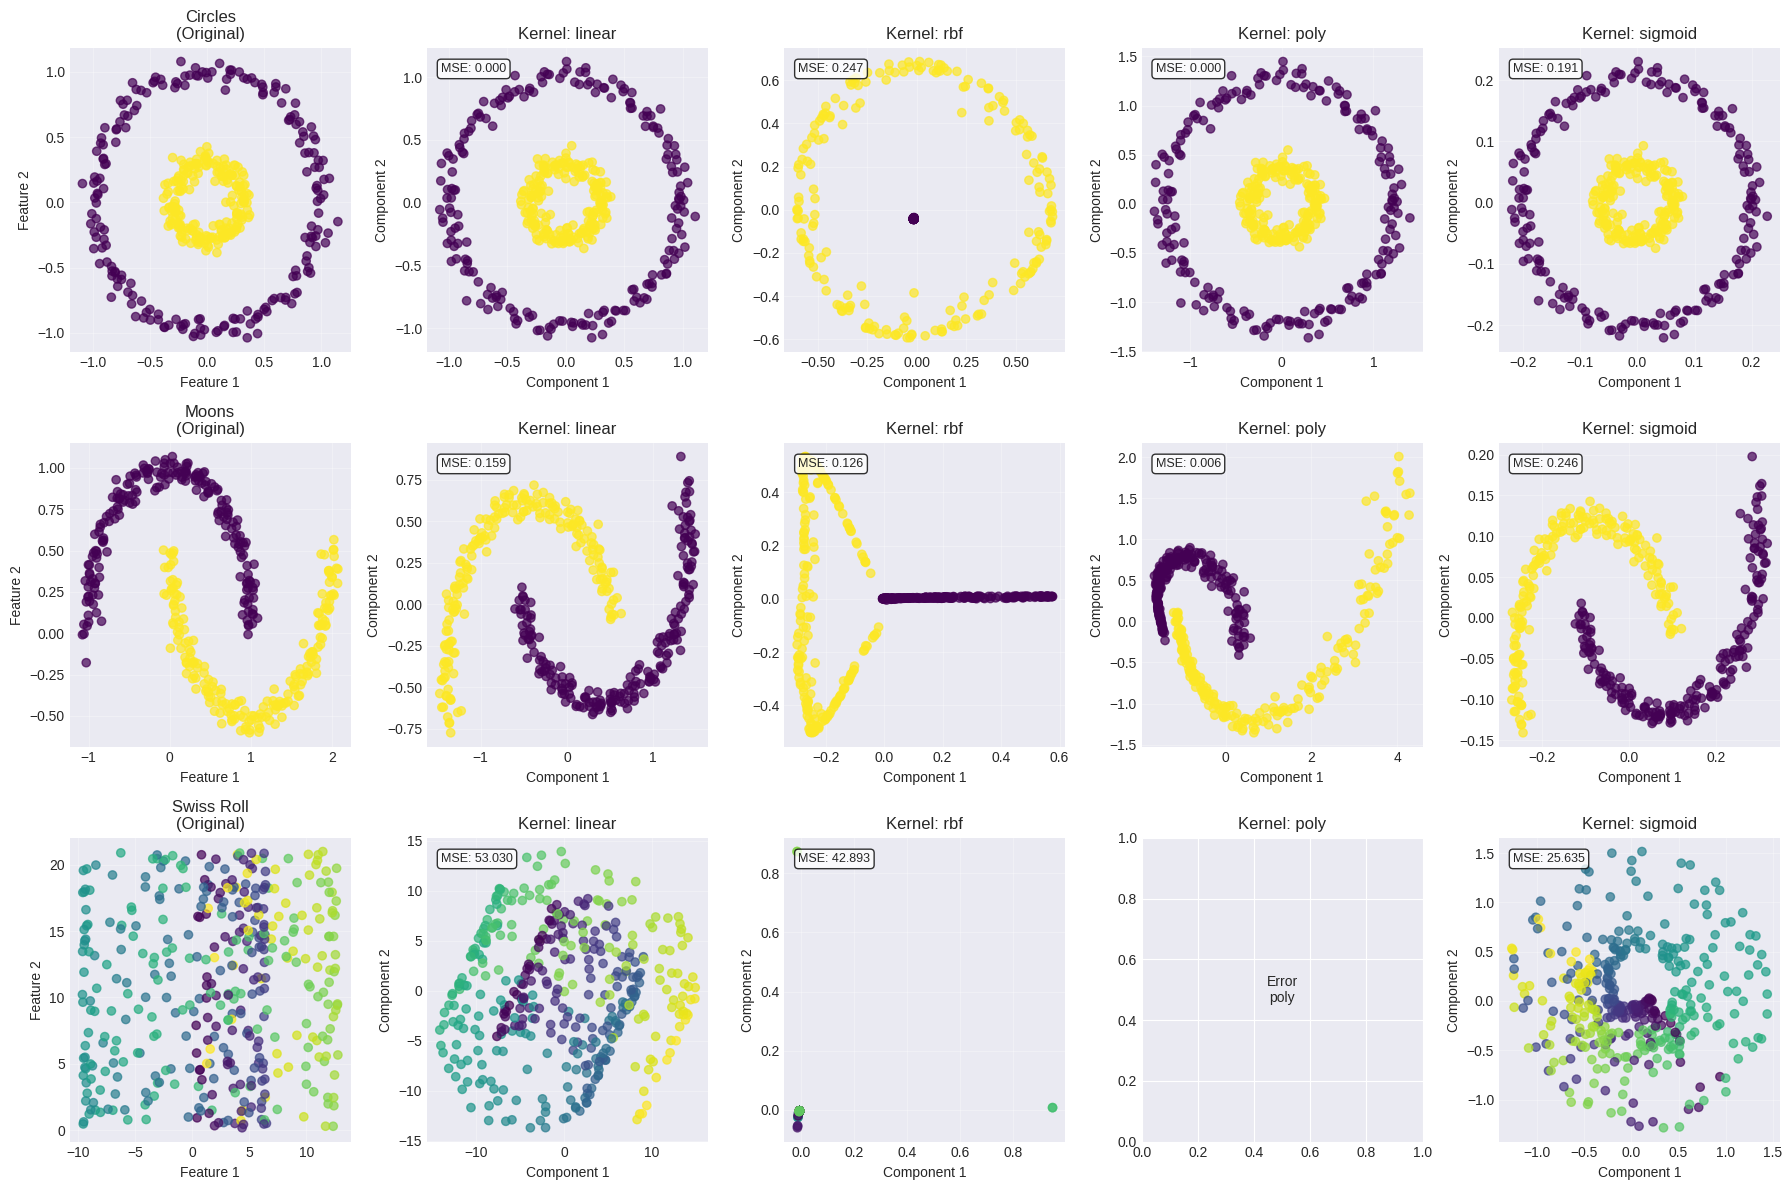

ANALISIS KERNEL PCA:
1. Linear Kernel: Sama dengan PCA biasa, hanya untuk data linear
2. RBF Kernel: Terbaik untuk data dengan struktur lokal/kluster
3. Poly Kernel: Cocok untuk hubungan polynomial
4. Sigmoid Kernel: Mirip neural network, cocok untuk beberapa kasus khusus


In [7]:
from sklearn.decomposition import KernelPCA
from sklearn.datasets import make_circles, make_moons

# Buat dataset nonlinear
X_circle, y_circle = make_circles(n_samples=400, factor=0.3, noise=0.05, random_state=42)
X_moons, y_moons = make_moons(n_samples=400, noise=0.05, random_state=42)

# Visualisasi Kernel PCA dengan berbagai kernel
fig, axes = plt.subplots(3, 5, figsize=(18, 12)) # Changed 4 to 5 here

datasets = [
    ('Circles', X_circle, y_circle),
    ('Moons', X_moons, y_moons),
    ('Swiss Roll', X_swiss[:400], t_swiss[:400])
]

kernels = ['linear', 'rbf', 'poly', 'sigmoid']
params = [
    {'kernel': 'linear'},
    {'kernel': 'rbf', 'gamma': 15},
    {'kernel': 'poly', 'degree': 3, 'coef0': 1},
    {'kernel': 'sigmoid', 'gamma': 0.1, 'coef0': 1}
]

for row, (dataset_name, X_data, y_data) in enumerate(datasets):
    # Plot data asli
    if dataset_name == 'Swiss Roll':
        ax_orig = axes[row, 0]
        scatter = ax_orig.scatter(X_data[:, 0], X_data[:, 1], c=y_data,
                                 cmap='viridis', alpha=0.7)
        ax_orig.set_title(f'{dataset_name}\n(2D projection)')
    else:
        ax_orig = axes[row, 0]
        scatter = ax_orig.scatter(X_data[:, 0], X_data[:, 1], c=y_data,
                                 cmap='viridis', alpha=0.7)
    ax_orig.set_title(f'{dataset_name}\n(Original)')
    ax_orig.set_xlabel('Feature 1')
    ax_orig.set_ylabel('Feature 2')
    ax_orig.grid(True, alpha=0.3)

    # Terapkan berbagai kernel PCA
    for col, (kernel_name, param) in enumerate(zip(kernels, params), 1):
        try:
            kpca = KernelPCA(n_components=2, **param, fit_inverse_transform=True)
            X_kpca = kpca.fit_transform(X_data)

            ax = axes[row, col]
            scatter = ax.scatter(X_kpca[:, 0], X_kpca[:, 1], c=y_data,
                                cmap='viridis', alpha=0.7)
            ax.set_title(f'Kernel: {kernel_name}')
            ax.set_xlabel('Component 1')
            ax.set_ylabel('Component 2')
            ax.grid(True, alpha=0.3)

            # Hitung reconstruction error jika tersedia
            if hasattr(kpca, 'inverse_transform'):
                X_reconstructed = kpca.inverse_transform(X_kpca)
                reconstruction_error = np.mean((X_data - X_reconstructed) ** 2)
                ax.text(0.05, 0.95, f'MSE: {reconstruction_error:.3f}',
                       transform=ax.transAxes, fontsize=9,
                       verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        except Exception as e:
            axes[row, col].text(0.5, 0.5, f'Error\n{kernel_name}',
                               ha='center', va='center', transform=axes[row, col].transAxes)
            axes[row, col].set_title(f'Kernel: {kernel_name}')

plt.tight_layout()
plt.show()

print("ANALISIS KERNEL PCA:")
print("1. Linear Kernel: Sama dengan PCA biasa, hanya untuk data linear")
print("2. RBF Kernel: Terbaik untuk data dengan struktur lokal/kluster")
print("3. Poly Kernel: Cocok untuk hubungan polynomial")
print("4. Sigmoid Kernel: Mirip neural network, cocok untuk beberapa kasus khusus")

### **Tuning Hyperparameters Kernel PCA**


Tuning Hyperparameters Kernel PCA:
----------------------------------------
Best parameters: {'kpca__gamma': np.float64(0.043333333333333335), 'kpca__kernel': 'rbf'}
Best cross-validation score: 0.847
Test set score: 0.825


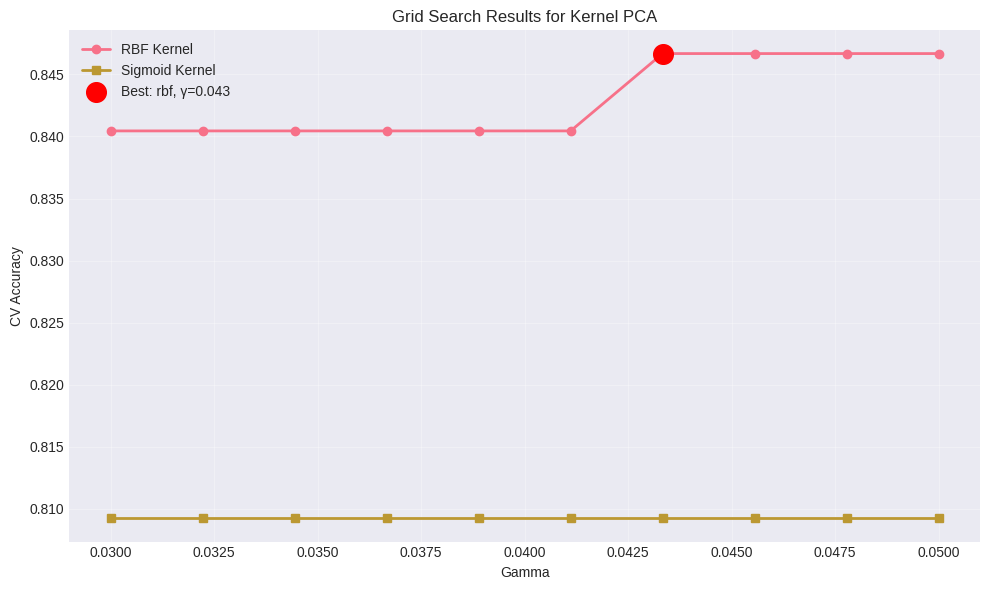

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Contoh tuning hyperparameters untuk Kernel PCA
print("\nTuning Hyperparameters Kernel PCA:")
print("-" * 40)

# Buat dataset klasifikasi
X_train, X_test, y_train, y_test = train_test_split(
    X_moons, y_moons, test_size=0.2, random_state=42
)

# Pipeline: KPCA + Logistic Regression
kpca_lr = Pipeline([
    ('kpca', KernelPCA(n_components=2)),
    ('log_reg', LogisticRegression(random_state=42))
])

# Grid search parameters
param_grid = [{
    'kpca__gamma': np.linspace(0.03, 0.05, 10),
    'kpca__kernel': ['rbf', 'sigmoid']
}]

grid_search = GridSearchCV(kpca_lr, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")
print(f"Test set score: {grid_search.score(X_test, y_test):.3f}")

# Visualisasi hasil grid search
fig, ax = plt.subplots(figsize=(10, 6))

# Ekstrak hasil grid search
results = grid_search.cv_results_
mean_scores = results['mean_test_score']
params = results['params']

# Pisahkan berdasarkan kernel
rbf_scores = []
sigmoid_scores = []
gammas = np.linspace(0.03, 0.05, 10)

for score, param in zip(mean_scores, params):
    if param['kpca__kernel'] == 'rbf':
        rbf_scores.append(score)
    else:
        sigmoid_scores.append(score)

ax.plot(gammas, rbf_scores, 'o-', label='RBF Kernel', linewidth=2)
ax.plot(gammas, sigmoid_scores, 's-', label='Sigmoid Kernel', linewidth=2)
ax.set_xlabel('Gamma')
ax.set_ylabel('CV Accuracy')
ax.set_title('Grid Search Results for Kernel PCA')
ax.legend()
ax.grid(True, alpha=0.3)

# Tandai best parameter
best_idx = np.argmax(mean_scores)
best_gamma = params[best_idx]['kpca__gamma']
best_kernel = params[best_idx]['kpca__kernel']
best_score = mean_scores[best_idx]

ax.scatter(best_gamma, best_score, color='red', s=200,
          zorder=5, label=f'Best: {best_kernel}, γ={best_gamma:.3f}')
ax.legend()

plt.tight_layout()
plt.show()

# **7. Locally Linear Embedding (LLE)**
---
LLE adalah teknik Manifold Learning yang:
* Memodelkan setiap titik sebagai kombinasi linear dari tetangga terdekat
* Mencari representasi dimensi rendah yang mempertahankan hubungan lokal ini
* Sangat baik untuk mengungkap manifold seperti Swiss Roll

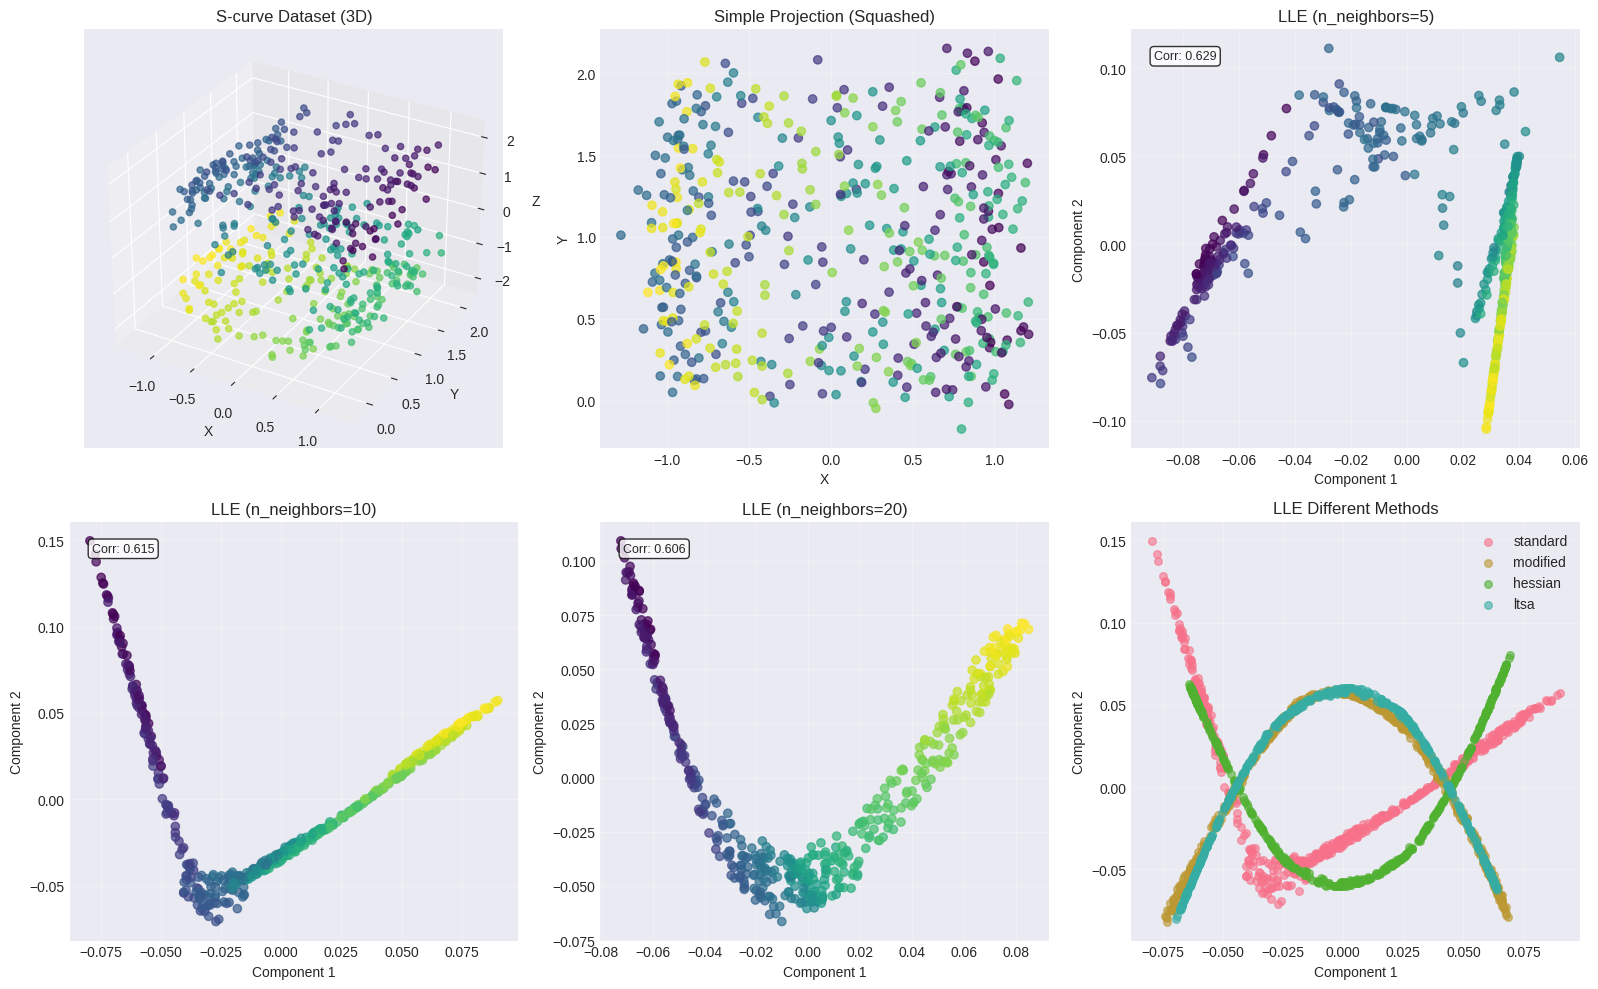

ANALISIS LLE:
1. n_neighbors: Mempengaruhi kualitas embedding
   - Terlalu kecil: overfitting, noise sensitive
   - Terlalu besar: kehilangan struktur lokal
2. Methods:
   - standard: LLE original
   - modified: lebih robust
   - hessian: Hessian Eigenmapping
   - ltsa: Local Tangent Space Alignment


In [9]:
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.datasets import make_s_curve

# Buat dataset S-curve (mirip Swiss Roll)
X_scurve, t_scurve = make_s_curve(n_samples=500, noise=0.1, random_state=42)

# Visualisasi LLE dengan berbagai parameter
fig = plt.figure(figsize=(16, 10))

# 1. Data asli (3D)
ax1 = fig.add_subplot(2, 3, 1, projection='3d')
ax1.scatter(X_scurve[:, 0], X_scurve[:, 1], X_scurve[:, 2],
           c=t_scurve, cmap='viridis', alpha=0.7)
ax1.set_title('S-curve Dataset (3D)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# 2. Projection sederhana (salah)
ax2 = fig.add_subplot(2, 3, 2)
ax2.scatter(X_scurve[:, 0], X_scurve[:, 1], c=t_scurve, cmap='viridis', alpha=0.7)
ax2.set_title('Simple Projection (Squashed)')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.grid(True, alpha=0.3)

# 3. LLE dengan n_neighbors berbeda
n_neighbors_list = [5, 10, 20]
colors = ['red', 'green', 'blue']

for idx, n_neighbors in enumerate(n_neighbors_list):
    lle = LocallyLinearEmbedding(n_components=2, n_neighbors=n_neighbors,
                                random_state=42, method='standard')
    X_lle = lle.fit_transform(X_scurve)

    ax = fig.add_subplot(2, 3, 3+idx)
    scatter = ax.scatter(X_lle[:, 0], X_lle[:, 1], c=t_scurve,
                        cmap='viridis', alpha=0.7)
    ax.set_title(f'LLE (n_neighbors={n_neighbors})')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.grid(True, alpha=0.3)

    # Hitung preservation of local structure
    from sklearn.metrics import pairwise_distances
    orig_dist = pairwise_distances(X_scurve[:100])  # Ambil subset untuk efisiensi
    embed_dist = pairwise_distances(X_lle[:100])

    # Hitung correlation antara distances
    corr = np.corrcoef(orig_dist.flatten(), embed_dist.flatten())[0, 1]
    ax.text(0.05, 0.95, f'Corr: {corr:.3f}',
           transform=ax.transAxes, fontsize=9,
           verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 6. Perbandingan metode LLE
methods = ['standard', 'modified', 'hessian', 'ltsa']
X_lle_methods = []

for method in methods:
    try:
        lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10,
                                    method=method, random_state=42)
        X_lle_methods.append((method, lle.fit_transform(X_scurve)))
    except:
        X_lle_methods.append((method, None))

ax6 = fig.add_subplot(2, 3, 6)
for method, X_transformed in X_lle_methods:
    if X_transformed is not None:
        ax6.scatter(X_transformed[:, 0], X_transformed[:, 1],
                   alpha=0.6, label=method, s=30)
ax6.set_title('LLE Different Methods')
ax6.set_xlabel('Component 1')
ax6.set_ylabel('Component 2')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("ANALISIS LLE:")
print("1. n_neighbors: Mempengaruhi kualitas embedding")
print("   - Terlalu kecil: overfitting, noise sensitive")
print("   - Terlalu besar: kehilangan struktur lokal")
print("2. Methods:")
print("   - standard: LLE original")
print("   - modified: lebih robust")
print("   - hessian: Hessian Eigenmapping")
print("   - ltsa: Local Tangent Space Alignment")

# **8. Other Dimensionality Reduction Techniques**
---

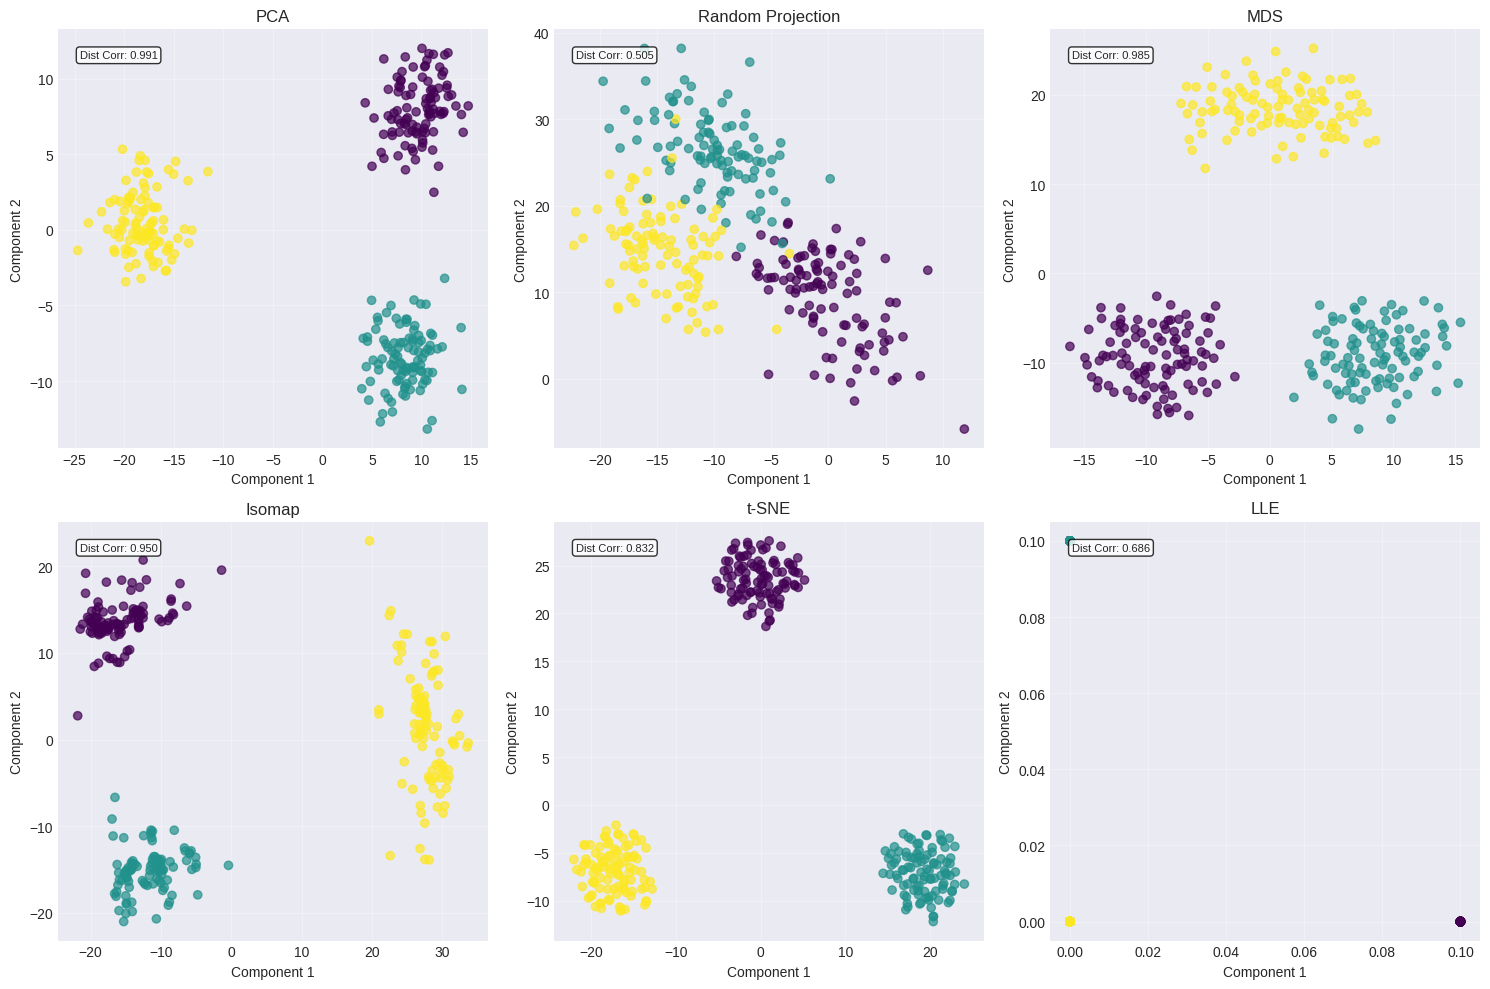

RINGKASAN TEKNIK REDUKSI DIMENSI

PCA:
  Type: Linear
  Strengths: Cepat, interpretable, baik untuk data linear
  Weaknesses: Tidak menangani data nonlinear
  Best for: Compression, visualization linear data
  Time Complexity: O(n³) untuk SVD full

Kernel PCA:
  Type: Nonlinear
  Strengths: Menangani data nonlinear, berbagai kernel
  Weaknesses: Lambat untuk dataset besar, pilih kernel sulit
  Best for: Data nonlinear dengan struktur kluster
  Time Complexity: O(n³) atau O(n²) untuk approximate

LLE:
  Type: Manifold Learning
  Strengths: Baik untuk mengungkap manifold, preservasi lokal
  Weaknesses: Skala buruk (O(n²)), sensitif parameter
  Best for: Swiss roll-type manifolds
  Time Complexity: O(n²)

t-SNE:
  Type: Manifold Learning
  Strengths: Visualisasi sangat baik, preservasi lokal
  Weaknesses: Hanya untuk visualisasi, tidak untuk feature reduction
  Best for: Data visualization, cluster discovery
  Time Complexity: O(n²)

Random Projection:
  Type: Projection
  Strengths: Sang

In [10]:
from sklearn.manifold import MDS, Isomap, TSNE
from sklearn.random_projection import GaussianRandomProjection

# Visualisasi berbagai teknik reduksi dimensi
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Dataset untuk visualisasi
X_viz, y_viz = make_blobs(n_samples=300, n_features=10, centers=3,
                         cluster_std=2.0, random_state=42)

techniques = [
    ('PCA', PCA(n_components=2)),
    ('Random Projection', GaussianRandomProjection(n_components=2, random_state=42)),
    ('MDS', MDS(n_components=2, random_state=42)),
    ('Isomap', Isomap(n_components=2, n_neighbors=10)),
    ('t-SNE', TSNE(n_components=2, random_state=42)),
    ('LLE', LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42))
]

for idx, (name, reducer) in enumerate(techniques):
    row = idx // 3
    col = idx % 3

    try:
        X_reduced = reducer.fit_transform(X_viz)

        axes[row, col].scatter(X_reduced[:, 0], X_reduced[:, 1],
                              c=y_viz, cmap='viridis', alpha=0.7)
        axes[row, col].set_title(name)
        axes[row, col].set_xlabel('Component 1')
        axes[row, col].set_ylabel('Component 2')
        axes[row, col].grid(True, alpha=0.3)

        # Hitung preservation of pairwise distances
        from scipy.spatial.distance import pdist
        orig_dist = pdist(X_viz[:100])
        redu_dist = pdist(X_reduced[:100])
        corr = np.corrcoef(orig_dist, redu_dist)[0, 1]

        axes[row, col].text(0.05, 0.95, f'Dist Corr: {corr:.3f}',
                           transform=axes[row, col].transAxes, fontsize=8,
                           verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    except Exception as e:
        axes[row, col].text(0.5, 0.5, f'Error\n{name}',
                           ha='center', va='center')
        axes[row, col].set_title(name)

plt.tight_layout()
plt.show()

# Ringkasan karakteristik teknik
print("="*70)
print("RINGKASAN TEKNIK REDUKSI DIMENSI")
print("="*70)

technique_info = {
    'PCA': {
        'Type': 'Linear',
        'Strengths': 'Cepat, interpretable, baik untuk data linear',
        'Weaknesses': 'Tidak menangani data nonlinear',
        'Best for': 'Compression, visualization linear data',
        'Time Complexity': 'O(n³) untuk SVD full'
    },
    'Kernel PCA': {
        'Type': 'Nonlinear',
        'Strengths': 'Menangani data nonlinear, berbagai kernel',
        'Weaknesses': 'Lambat untuk dataset besar, pilih kernel sulit',
        'Best for': 'Data nonlinear dengan struktur kluster',
        'Time Complexity': 'O(n³) atau O(n²) untuk approximate'
    },
    'LLE': {
        'Type': 'Manifold Learning',
        'Strengths': 'Baik untuk mengungkap manifold, preservasi lokal',
        'Weaknesses': 'Skala buruk (O(n²)), sensitif parameter',
        'Best for': 'Swiss roll-type manifolds',
        'Time Complexity': 'O(n²)'
    },
    't-SNE': {
        'Type': 'Manifold Learning',
        'Strengths': 'Visualisasi sangat baik, preservasi lokal',
        'Weaknesses': 'Hanya untuk visualisasi, tidak untuk feature reduction',
        'Best for': 'Data visualization, cluster discovery',
        'Time Complexity': 'O(n²)'
    },
    'Random Projection': {
        'Type': 'Projection',
        'Strengths': 'Sangat cepat, preservasi jarak (Johnson-Lindenstrauss)',
        'Weaknesses': 'Random, hasil bervariasi',
        'Best for': 'Very high-dimensional data, speed critical',
        'Time Complexity': 'O(ndk)'
    },
    'MDS': {
        'Type': 'Manifold Learning',
        'Strengths': 'Preservasi jarak global',
        'Weaknesses': 'Sangat lambat untuk dataset besar',
        'Best for': 'Small datasets, preservation of distances',
        'Time Complexity': 'O(n³)'
    }
}

for technique, info in technique_info.items():
    print(f"\n{technique}:")
    print(f"  Type: {info['Type']}")
    print(f"  Strengths: {info['Strengths']}")
    print(f"  Weaknesses: {info['Weaknesses']}")
    print(f"  Best for: {info['Best for']}")
    print(f"  Time Complexity: {info['Time Complexity']}")

print("\n" + "="*70)
print("REKOMENDASI PEMILIHAN TEKNIK:")
print("1. Untuk compression/feature reduction cepat: PCA atau Random Projection")
print("2. Untuk visualisasi data nonlinear: t-SNE (terbaik), UMAP")
print("3. Untuk mengungkap manifold: LLE, Isomap")
print("4. Untuk preservasi jarak: MDS")
print("5. Untuk data sangat besar: Incremental PCA, Random Projection")
print("6. Untuk klasifikasi/regresi: Kernel PCA + grid search")
print("="*70)

# **9. Contoh Praktis: MNIST Dataset**
---

Loading MNIST dataset...
Training set: (8000, 784)
Test set: (2000, 784)

EXPERIMENT 1: Random Forest tanpa Dimensionality Reduction
Training time: 5.24 seconds
Accuracy: 0.9465

EXPERIMENT 2: Random Forest dengan PCA (95% variance)
Original dimensions: 784
Reduced dimensions: 151
Compression ratio: 19.3%

Training time: 12.29 seconds
Speedup: 0.4x
Accuracy: 0.9170
Accuracy difference: -0.0295

EXPERIMENT 3: Visualisasi MNIST dengan berbagai teknik
Running PCA... done in 0.1s
Running Kernel PCA (RBF)... done in 0.2s
Running t-SNE... done in 7.8s
Running LLE... done in 0.5s
Running MDS... done in 5.9s
Running Isomap... done in 0.4s


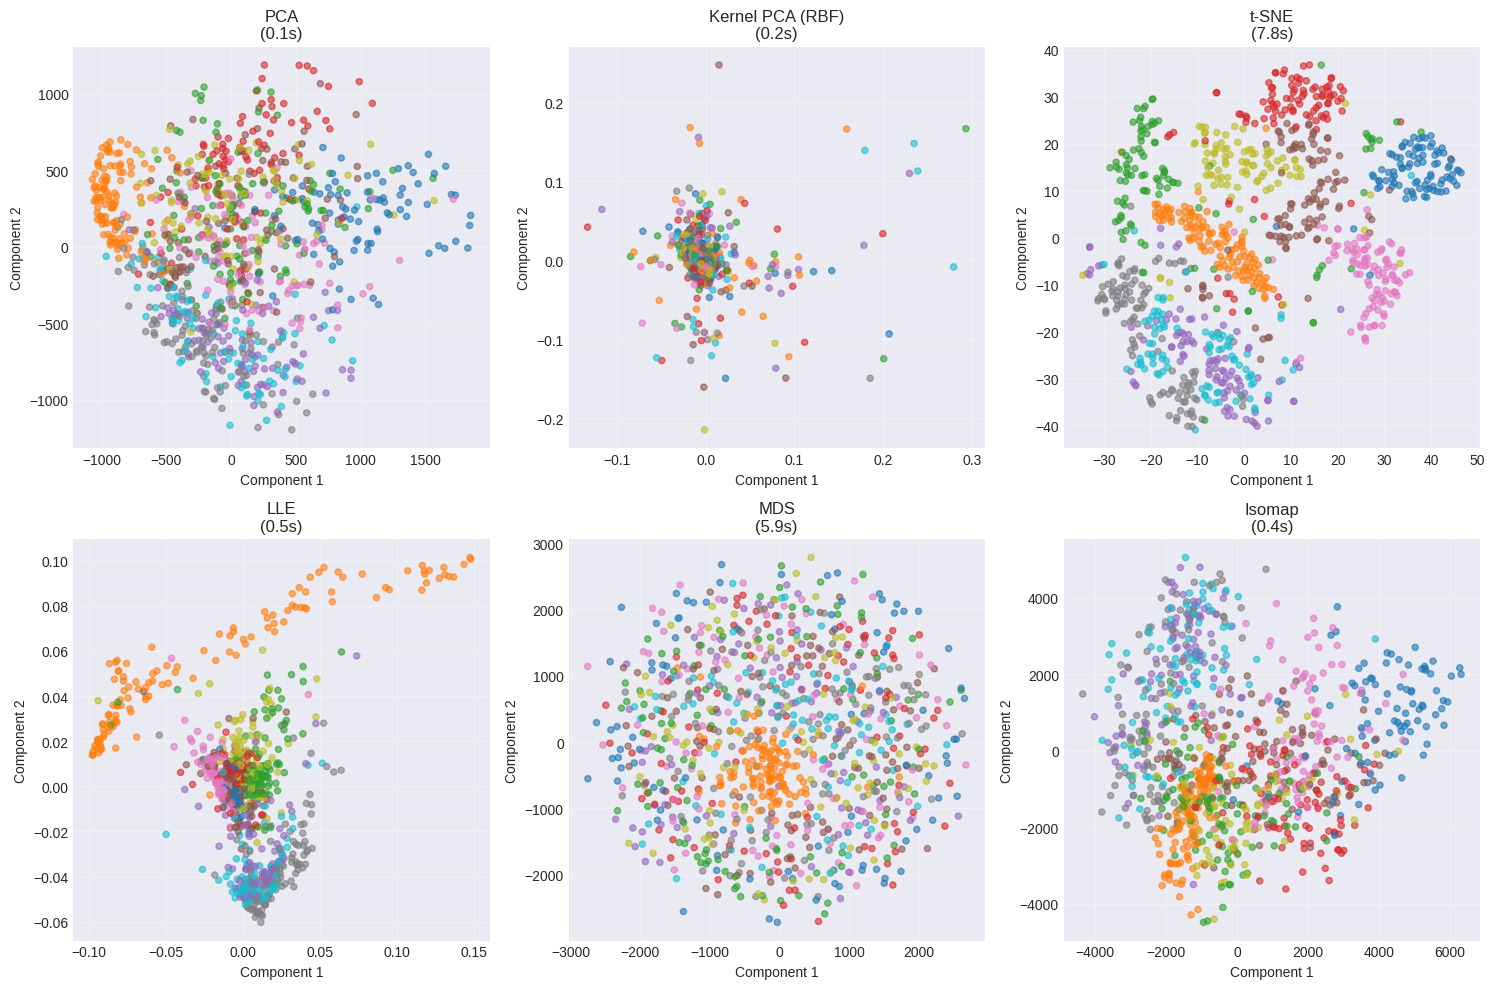


Visualisasi Digit Asli vs Rekonstruksi PCA:


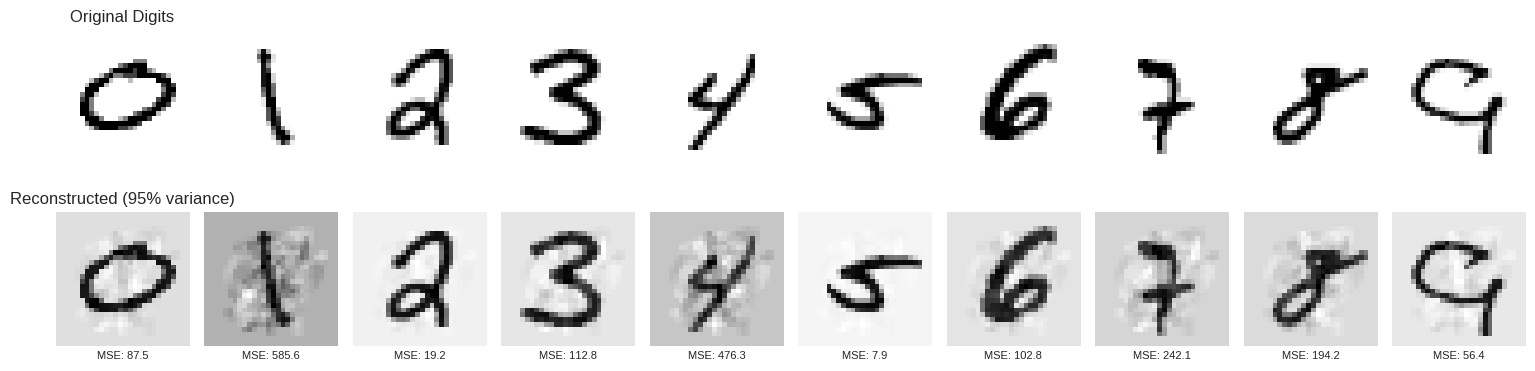


KESIMPULAN EKSPERIMEN MNIST:
1. Tanpa reduksi dimensi:
   - Accuracy: 0.9465
   - Training time: 5.24s
   - Dimensions: 784

2. Dengan PCA (95% variance):
   - Accuracy: 0.9170 (-0.0295)
   - Training time: 12.29s (0.4x faster)
   - Dimensions: 151 (compression: 19.3%)

3. Analisis Visualisasi:
   - PCA: Cepat, mempertahankan struktur global
   - t-SNE: Terbaik untuk visualisasi cluster
   - LLE: Baik untuk struktur lokal
   - MDS: Preservasi jarak tapi lambat
   - Isomap: Baik untuk manifold geodesic

REKOMENDASI UNTUK MNIST/DATASET SEJENIS:
1. Untuk klasifikasi: Gunakan PCA dengan 95-99% variance
2. Untuk visualisasi: Gunakan t-SNE (meskipun lambat)
3. Untuk real-time: Gunakan Incremental PCA atau Random Projection
4. Trade-off: Kecepatan vs akurasi vs interpretability


In [11]:
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time

# Load MNIST dataset
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X_mnist = mnist.data
y_mnist = mnist.target.astype(int)

# Ambil subset untuk efisiensi (10k samples)
indices = np.random.choice(len(X_mnist), 10000, replace=False)
X_subset = X_mnist[indices]
y_subset = y_mnist[indices]

# Split train-test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_subset, y_subset, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Eksperimen 1: Random Forest tanpa reduksi dimensi
print("\n" + "="*60)
print("EXPERIMENT 1: Random Forest tanpa Dimensionality Reduction")
print("="*60)

rf_full = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

start = time.time()
rf_full.fit(X_train, y_train)
full_time = time.time() - start

y_pred_full = rf_full.predict(X_test)
acc_full = accuracy_score(y_test, y_pred_full)

print(f"Training time: {full_time:.2f} seconds")
print(f"Accuracy: {acc_full:.4f}")

# Eksperimen 2: Random Forest dengan PCA (95% variance)
print("\n" + "="*60)
print("EXPERIMENT 2: Random Forest dengan PCA (95% variance)")
print("="*60)

# Lakukan PCA untuk 95% variance
pca_mnist = PCA(n_components=0.95)
X_train_pca = pca_mnist.fit_transform(X_train)
X_test_pca = pca_mnist.transform(X_test)

print(f"Original dimensions: {X_train.shape[1]}")
print(f"Reduced dimensions: {X_train_pca.shape[1]}")
print(f"Compression ratio: {X_train_pca.shape[1]/X_train.shape[1]:.1%}")

rf_pca = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

start = time.time()
rf_pca.fit(X_train_pca, y_train)
pca_time = time.time() - start

y_pred_pca = rf_pca.predict(X_test_pca)
acc_pca = accuracy_score(y_test, y_pred_pca)

print(f"\nTraining time: {pca_time:.2f} seconds")
print(f"Speedup: {full_time/pca_time:.1f}x")
print(f"Accuracy: {acc_pca:.4f}")
print(f"Accuracy difference: {acc_pca - acc_full:+.4f}")

# Eksperimen 3: Visualisasi dengan berbagai teknik
print("\n" + "="*60)
print("EXPERIMENT 3: Visualisasi MNIST dengan berbagai teknik")
print("="*60)

# Ambil subset kecil untuk visualisasi
viz_indices = np.random.choice(len(X_train), 1000, replace=False)
X_viz = X_train[viz_indices]
y_viz = y_train[viz_indices]

# Buat visualisasi
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

viz_techniques = [
    ('PCA', PCA(n_components=2)),
    ('Kernel PCA (RBF)', KernelPCA(n_components=2, kernel='rbf', gamma=0.001)),
    ('t-SNE', TSNE(n_components=2, random_state=42)),
    ('LLE', LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)),
    ('MDS', MDS(n_components=2, random_state=42, max_iter=50)),
    ('Isomap', Isomap(n_components=2, n_neighbors=10))
]

for idx, (name, reducer) in enumerate(viz_techniques):
    row = idx // 3
    col = idx % 3

    print(f"Running {name}...", end=' ')
    start = time.time()

    try:
        X_reduced = reducer.fit_transform(X_viz)

        scatter = axes[row, col].scatter(X_reduced[:, 0], X_reduced[:, 1],
                                        c=y_viz, cmap='tab10', alpha=0.6, s=20)
        axes[row, col].set_title(f'{name}\n({time.time()-start:.1f}s)')
        axes[row, col].set_xlabel('Component 1')
        axes[row, col].set_ylabel('Component 2')
        axes[row, col].grid(True, alpha=0.3)

        print(f"done in {time.time()-start:.1f}s")

    except Exception as e:
        axes[row, col].text(0.5, 0.5, f'Error\n{name}',
                           ha='center', va='center')
        axes[row, col].set_title(name)
        print(f"error: {str(e)}")

plt.tight_layout()
plt.show()

# Visualisasi digit asli vs rekonstruksi PCA
print("\nVisualisasi Digit Asli vs Rekonstruksi PCA:")
fig, axes = plt.subplots(2, 10, figsize=(15, 4))

# Ambil 10 digit contoh
sample_digits = []
for digit in range(10):
    idx = np.where(y_train == digit)[0][0]
    sample_digits.append(X_train[idx])

sample_digits = np.array(sample_digits)

# Lakukan PCA dan rekonstruksi
pca_digits = PCA(n_components=0.95)  # Changed from 154 to 0.95 to align with sample_digits (10 samples) and retain variance
X_digits_pca = pca_digits.fit_transform(sample_digits)
X_digits_recon = pca_digits.inverse_transform(X_digits_pca)

# Plot digit asli
for i in range(10):
    ax = axes[0, i]
    ax.imshow(sample_digits[i].reshape(28, 28), cmap='binary')
    ax.axis('off')
    if i == 0:
        ax.set_title('Original Digits', fontsize=12)

# Plot digit rekonstruksi
for i in range(10):
    ax = axes[1, i]
    ax.imshow(X_digits_recon[i].reshape(28, 28), cmap='binary')
    ax.axis('off')
    if i == 0:
        ax.set_title('Reconstructed (95% variance)', fontsize=12)

    # Hitung reconstruction error
    mse = np.mean((sample_digits[i] - X_digits_recon[i]) ** 2)
    ax.text(0.5, -0.1, f'MSE: {mse:.1f}', transform=ax.transAxes,
           ha='center', fontsize=8)

plt.tight_layout()
plt.show()

# Ringkasan hasil eksperimen
print("\n" + "="*70)
print("KESIMPULAN EKSPERIMEN MNIST:")
print("="*70)
print(f"1. Tanpa reduksi dimensi:")
print(f"   - Accuracy: {acc_full:.4f}")
print(f"   - Training time: {full_time:.2f}s")
print(f"   - Dimensions: {X_train.shape[1]}")

print(f"\n2. Dengan PCA (95% variance):")
print(f"   - Accuracy: {acc_pca:.4f} ({acc_pca - acc_full:+.4f})")
print(f"   - Training time: {pca_time:.2f}s ({full_time/pca_time:.1f}x faster)")
print(f"   - Dimensions: {X_train_pca.shape[1]} (compression: {X_train_pca.shape[1]/X_train.shape[1]:.1%})")

print(f"\n3. Analisis Visualisasi:")
print("   - PCA: Cepat, mempertahankan struktur global")
print("   - t-SNE: Terbaik untuk visualisasi cluster")
print("   - LLE: Baik untuk struktur lokal")
print("   - MDS: Preservasi jarak tapi lambat")
print("   - Isomap: Baik untuk manifold geodesic")

print("\n" + "="*70)
print("REKOMENDASI UNTUK MNIST/DATASET SEJENIS:")
print("1. Untuk klasifikasi: Gunakan PCA dengan 95-99% variance")
print("2. Untuk visualisasi: Gunakan t-SNE (meskipun lambat)")
print("3. Untuk real-time: Gunakan Incremental PCA atau Random Projection")
print("4. Trade-off: Kecepatan vs akurasi vs interpretability")
print("="*70)

# **10. Exercises dan Implementasi**
---

EXERCISES IMPLEMENTATION:

Exercise 5: Menghitung dimensions untuk 95% variance
Dimensi untuk 95% variance: 151
Persentase dimensi asli: 19.3%

Exercise 8: Chaining dimensionality reduction algorithms


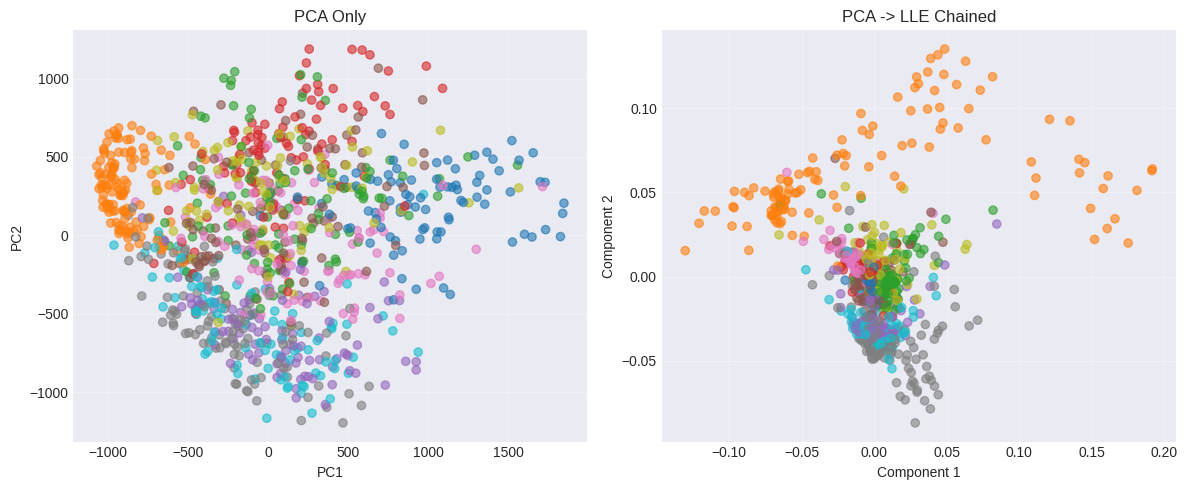

Analisis chaining:
- Keuntungan: Dapat mengatasi limitasi masing-masing algoritma
- PCA: Efisien mengurangi dimensi tinggi
- LLE: Baik untuk manifold learning tapi lambat di dimensi tinggi
- Pipeline: Kombinasi terbaik dari kedua dunia


In [12]:
print("EXERCISES IMPLEMENTATION:")
print("="*60)

# Exercise 5: Menghitung dimensions untuk 95% variance
print("\nExercise 5: Menghitung dimensions untuk 95% variance")
pca_exercise = PCA()
pca_exercise.fit(X_train)
cumsum = np.cumsum(pca_exercise.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(f"Dimensi untuk 95% variance: {d}")
print(f"Persentase dimensi asli: {d/X_train.shape[1]:.1%}")

# Exercise 8: Chaining dimensionality reduction algorithms
print("\nExercise 8: Chaining dimensionality reduction algorithms")
from sklearn.pipeline import Pipeline

# Pipeline: PCA -> LLE
pipeline = Pipeline([
    ('pca', PCA(n_components=100)),  # Reduce to 100 dimensions first
    ('lle', LocallyLinearEmbedding(n_components=2, n_neighbors=10))
])

X_chained = pipeline.fit_transform(X_viz)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Hanya PCA
pca_only = PCA(n_components=2)
X_pca_only = pca_only.fit_transform(X_viz)
ax1.scatter(X_pca_only[:, 0], X_pca_only[:, 1], c=y_viz, cmap='tab10', alpha=0.6)
ax1.set_title('PCA Only')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.grid(True, alpha=0.3)

# PCA + LLE chained
ax2.scatter(X_chained[:, 0], X_chained[:, 1], c=y_viz, cmap='tab10', alpha=0.6)
ax2.set_title('PCA -> LLE Chained')
ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Analisis chaining:")
print("- Keuntungan: Dapat mengatasi limitasi masing-masing algoritma")
print("- PCA: Efisien mengurangi dimensi tinggi")
print("- LLE: Baik untuk manifold learning tapi lambat di dimensi tinggi")
print("- Pipeline: Kombinasi terbaik dari kedua dunia")